# SPE GCS ML Challenge 2021
By: Doa Ibu Team
- Raden Sasangka Ardi Nugraha 
- Mordekhai
- Luthfi Nurul Hidayah Saifudin
- Alfian Rahman

In [1]:
# Install dependencies
# !pip install -r requirements.txt --user --quiet

In [2]:
import json
import lasio 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import zipfile
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

## Data Preprocessing

In [3]:
def load_data(filename):
    l = lasio.read(filename)
    data_well = l.df()
    log = list(data_well.columns.values)
    header = [{
        'WELL': filename, 
        'START':l.well.STRT.value,
        'STOP':l.well.STOP.value,
        'STEP':l.well.STEP.value,
        'LAT':l.well.SLAT.value,
        'LON':l.well.SLON.value,
        'DATUM':l.well.DATUM.value
    }]
    data_well['WELL'] = filename  

    log_list = pd.DataFrame(header)
    for newlog in log:
        log_list[newlog]= "v"
    return data_well, log_list

def merge_alias(db, alias, logs_selected):
    well = db['WELL'].unique()
    merged_data = pd.DataFrame()

    for i in range(len(well)):
        data = db.where(db['WELL']==well[i]).dropna(axis=1, how='all')
        for j in range(len(alias)):
            welllog_name = list(set(data.columns).intersection(alias.get(list(alias)[j])))
            samelog = data[welllog_name]
            count_log = dict(sorted(zip(welllog_name, samelog.count()), key=lambda item: item[1], reverse=True))
            welllog_name = list(count_log.keys())
            if (len(welllog_name)!=0):
                #If more than one log aliases exist, normalize each log to have same data range in the same depth
                if (len(welllog_name)>1):
                    alias_logs = data[welllog_name].dropna()
                    if (list(alias)[j] not in ['CAL','DTCO','DTSM']) and (len(alias_logs)!=0):
                        a = []; b = []; c = []
                        for n in range(len(alias_logs.columns)):
                            q1 = alias_logs[welllog_name[n]].quantile(0.1)
                            q9 = alias_logs[welllog_name[n]].quantile(0.9)
                            a.append(q1)
                            b.append(q9)
                            c = [b-a for (a,b) in zip(a,b)]
                            c = list(map(lambda x: x/c[0],c))
                        for n in range(len(welllog_name)):
                            data.loc[:, welllog_name[n]] *= 1/c[n]
                    for k in range(len(welllog_name)-1):
                        data[welllog_name[0]].fillna(data[welllog_name[k+1]], inplace=True)
                data[list(alias)[j]] = data[welllog_name[0]]
        merged_data = merged_data.append(data)
        merged_data = merged_data[merged_data['WELL'].notna()]
    merged_data = merged_data[logs_selected]
    return merged_data

In [4]:
##============================================================================
# train_source_dir: folder containing LAS files for train dataset
# test_source_dir: folder containing LAS files for test dataset
# alias_file: dictionaries of log alias in JSON format (key:main log name, value:list of log alias/es)
# logs_selected: list of log willing to be included in train and test dataset
#
# WARNING: Data loading and merging consumes a lot of memory. Unless you are running on a high computing device, 
# it is recommended to run the process in batch of 20-30 LAS files, then merge the result together.
##============================================================================

# UNCOMMENT THE CODES BELOW IF YOU WANT TO DO THE PROCESSING STEPS (IT MAY TAKE MINUTES OR HOURS) 

# #Initialization
# current_dir = os.getcwd()
# train_source_dir = '/data/train'
# test_source_dir = '/data/test'
# alias_file = '/data/alias.json'
# logs_selected= ['WELL', 'DEPT', 'CAL', 'SP', 'GR', 'POR', 'DRES', 'DTCO', 'PEF', 'DENS', 'DRHO']

# with open(current_dir + alias_file, 'r') as file:
#     alias = json.load(file)

# # Loading raw data for train dataset
# data_train = pd.DataFrame()
# log_ava_train = pd.DataFrame()
# for f in sorted(os.listdir(current_dir + train_source_dir)):
#     data_well, log_list = load_data(current_dir + f"/{train_source_dir}/{f}")
#     data_train = data_train.append(data_well)
#     log_ava_train = log_ava_train.append(log_list)

# # Merge log aliases for train dataset
# data_train = data_train.reset_index()
# train = merge_alias(data_train, alias, logs_selected).dropna()
# train.rename(columns={'POR':'NPHI', 'DENS':'RHOB'}, inplace=True)

# # Select well data which has more than 5000ft length
# log_ava_train['LENGTH'] = log_ava_train['STOP'] - log_ava_train['START']
# log_ava_train = log_ava_train.sort_values('LENGTH', ascending=False)
# well_selected = log_ava_train[log_ava_train['LENGTH'] > 10000]
# well_selected = well_selected['WELL']

# train = train[train['WELL'].isin(well_selected)]

# # Loading raw data for test dataset
# data_test = pd.DataFrame()
# log_ava_test = pd.DataFrame()
# for f in sorted(os.listdir(current_dir + test_source_dir)):
#     data_well, log_list = load_data(current_dir + f"/{test_source_dir}/{f}")
#     data_test = data_test.append(data_well)
#     log_ava_test = log_ava_test.append(log_list)

# # Merge log aliases for test dataset
# data_test = data_test.reset_index()
# test = merge_alias(data_test, alias, logs_selected)
# test.rename(columns={'POR':'NPHI', 'DENS':'RHOB'}, inplace=True)

# # Save loaded data
# train.to_csv('data/preprocessed/train.csv')
# test.to_csv('data/preprocessed/test.csv')

In [5]:
# #Display raw data distribution
# log_ava_train.count().plot(kind='bar', figsize=(35,7), title='Train Raw Data')
# log_ava_test.count().plot(kind='bar', figsize=(35,7), title='Test Raw Data')

In [6]:
# #Display data distribution - after merging aliases
# train.count().plot(kind='bar', figsize=(35,7), title='Train Data')
# test.count().plot(kind='bar', figsize=(35,7), title='Test Data', fontsize=20)

## Data Cleansing

In [7]:
df = pd.read_csv('data/preprocessed/train.csv')

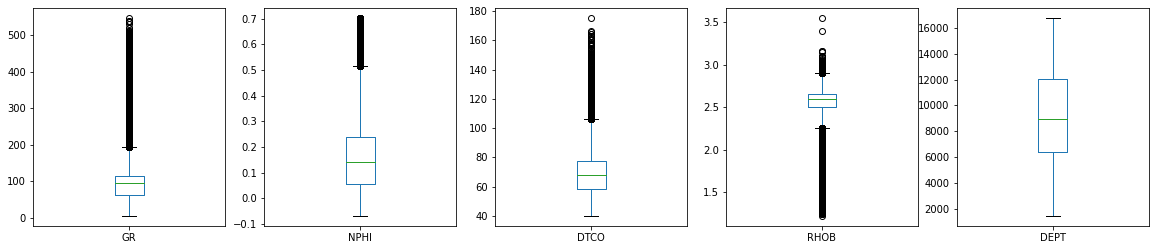

In [8]:
features = ['GR', 'NPHI', 'DTCO', 'RHOB', 'DEPT']

def plot_features_box_plot(df=df, features=features):
    plt.figure(figsize=(20, 4))

    for idx, feature in enumerate(features):   
        plt.subplot(1, len(features), idx+1)
        df[feature].plot.box()
    plt.show()

plot_features_box_plot()

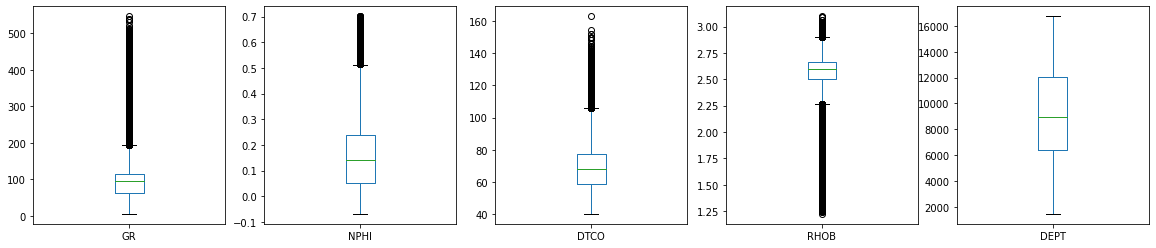

In [9]:
df = df.loc[
    (df['GR'] < 550) & 
    (df['DTCO'] < 170) & 
    (df['CAL'] >= 6) & (df['CAL'] <= 21) & 
    (df['PEF'] <= 10) &
    (df['RHOB'] <= 3.1) & 
    (df['SP'] <= 150), :]
df = df[df['DTCO'] < df['DTSM']]
plot_features_box_plot(df)

## Split Train & Test Data

In [10]:
X = df[features]
y = df['DTSM']

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

print('Total shape: ', df.shape)
print('Train shape: ', X_train.shape)
print('Test shape: ', X_test.shape)

Total shape:  (173880, 12)
Train shape:  (139104, 5)
Test shape:  (34776, 5)


## Model Building (XGBoost)

In [11]:
def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

In [12]:
model = XGBRegressor()
model.fit(X_train, y_train)

# Train performance
pred_train = model.predict(X_train)
print('RMSE train: ', rmse(y_train, pred_train))

# Test performance 
pred_test = model.predict(X_test)
print('RMSE test:', rmse(y_test, pred_test))

RMSE train:  8.298783496357233
RMSE test: 9.0421988835626


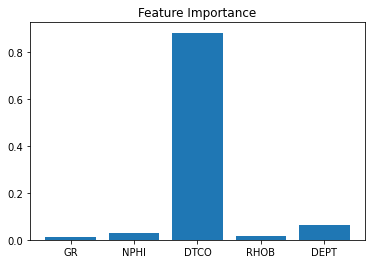

In [13]:
plt.bar(features, model.feature_importances_)
plt.title('Feature Importance')
plt.show()

## Interpolation

In [14]:
df_test = pd.read_csv('data/preprocessed/test.csv', index_col=0)
df_test.head()

,WELL,DEPT,CAL,SP,GR,NPHI,DRES,DTCO,PEF,RHOB,DRHO
0,00d02be79f49_TGS.las,9912.0,6.2363,12.2620,49.1883,0.4860,1900.9751,NaN,NaN,1.8771,-0.2491
1,00d02be79f49_TGS.las,9912.5,6.2481,5.1245,56.5820,0.4769,1990.3184,NaN,NaN,1.8989,-0.2487
2,00d02be79f49_TGS.las,9913.0,6.2844,-4.5998,68.5213,0.4480,1988.7848,NaN,NaN,2.0063,-0.2482
3,00d02be79f49_TGS.las,9913.5,6.6677,-14.8317,78.8782,0.3845,1987.2515,NaN,NaN,2.0603,-0.2478
4,00d02be79f49_TGS.las,9914.0,7.2943,-17.6811,83.4741,0.3215,1985.7203,NaN,NaN,2.1871,-0.2474


In [15]:
df_test['RHOB'] = df_test['RHOB'].apply(lambda x: np.nan if x >3.1 else x)
df_test['RHOB'] = df_test['RHOB'].apply(lambda x: np.nan if x <1 else x)

well_test = df_test['WELL'].unique()
df_test2 = pd.DataFrame()
for w in well_test:
    data = df_test.where(df_test['WELL']==w)
    data = data[['WELL','DEPT','RHOB', 'GR', 'PEF', 'SP','CAL', 'NPHI', 'DTCO']]
    data = data[data['DEPT'].notnull()]
    data = data.interpolate(method='linear', axis=0, limit_direction = 'both', limit_area=None)
    avggr = data['GR'].mean()
    avgcal = data['CAL'].mean()
    data['GR'] = data['GR'].apply(lambda x : x if x > 0 else avggr)
    data['CAL'] = data['CAL'].apply(lambda x : x if x > 0 else avgcal)
    df_test2 = df_test2.append(data)

## Recheck Data

In [16]:
df_test2['DRES'] = np.nan
df_test2['DRHO'] = np.nan
df_test2[['WELL','DEPT','CAL','SP','GR','NPHI','DRES','DTCO','PEF','RHOB','DRHO']]
print(df_test2.head())
print(df_test2.isna().sum())
print(len(df_test2))

                   WELL    DEPT    RHOB       GR  PEF       SP     CAL  \
0  00d02be79f49_TGS.las  9912.0  1.8771  49.1883  NaN  12.2620  6.2363   
1  00d02be79f49_TGS.las  9912.5  1.8989  56.5820  NaN   5.1245  6.2481   
2  00d02be79f49_TGS.las  9913.0  2.0063  68.5213  NaN  -4.5998  6.2844   
3  00d02be79f49_TGS.las  9913.5  2.0603  78.8782  NaN -14.8317  6.6677   
4  00d02be79f49_TGS.las  9914.0  2.1871  83.4741  NaN -17.6811  7.2943   

     NPHI     DTCO  DRES  DRHO  
0  0.4860  94.7319   NaN   NaN  
1  0.4769  94.7319   NaN   NaN  
2  0.4480  94.7319   NaN   NaN  
3  0.3845  94.7319   NaN   NaN  
4  0.3215  94.7319   NaN   NaN  
WELL         0
DEPT         0
RHOB         0
GR           0
PEF       2598
SP       31695
CAL      12846
NPHI         0
DTCO         0
DRES    148006
DRHO    148006
dtype: int64
148006


In [17]:
print(df_test.head())
print(df_test.isna().sum())
print(len(df_test))

                   WELL    DEPT     CAL       SP       GR    NPHI       DRES  \
0  00d02be79f49_TGS.las  9912.0  6.2363  12.2620  49.1883  0.4860  1900.9751   
1  00d02be79f49_TGS.las  9912.5  6.2481   5.1245  56.5820  0.4769  1990.3184   
2  00d02be79f49_TGS.las  9913.0  6.2844  -4.5998  68.5213  0.4480  1988.7848   
3  00d02be79f49_TGS.las  9913.5  6.6677 -14.8317  78.8782  0.3845  1987.2515   
4  00d02be79f49_TGS.las  9914.0  7.2943 -17.6811  83.4741  0.3215  1985.7203   

   DTCO  PEF    RHOB    DRHO  
0   NaN  NaN  1.8771 -0.2491  
1   NaN  NaN  1.8989 -0.2487  
2   NaN  NaN  2.0063 -0.2482  
3   NaN  NaN  2.0603 -0.2478  
4   NaN  NaN  2.1871 -0.2474  
WELL        0
DEPT        0
CAL     27408
SP      31701
GR        712
NPHI    20027
DRES    30384
DTCO      799
PEF     45107
RHOB    23998
DRHO    24246
dtype: int64
148006


## DTSM Prediction

In [18]:
dtsm_pred = model.predict(df_test2[list(X_train.columns)])
df_test2['DTSM_PRED'] = dtsm_pred

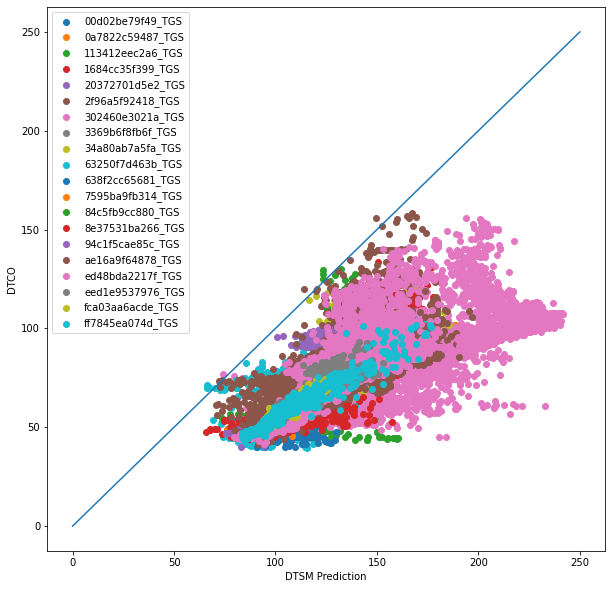

In [19]:
plt.figure(figsize=(10, 10))
for well in df_test2['WELL'].unique():
    plt.scatter(df_test2.loc[df_test['WELL'] == well, 'DTSM_PRED'], 
                df_test2.loc[df_test['WELL'] == well, 'DTCO'], label=well[:-4])
plt.plot(np.linspace(0,250,11), np.linspace(0,250,11))
plt.xlabel('DTSM Prediction')
plt.ylabel('DTCO')
plt.legend()
plt.show()

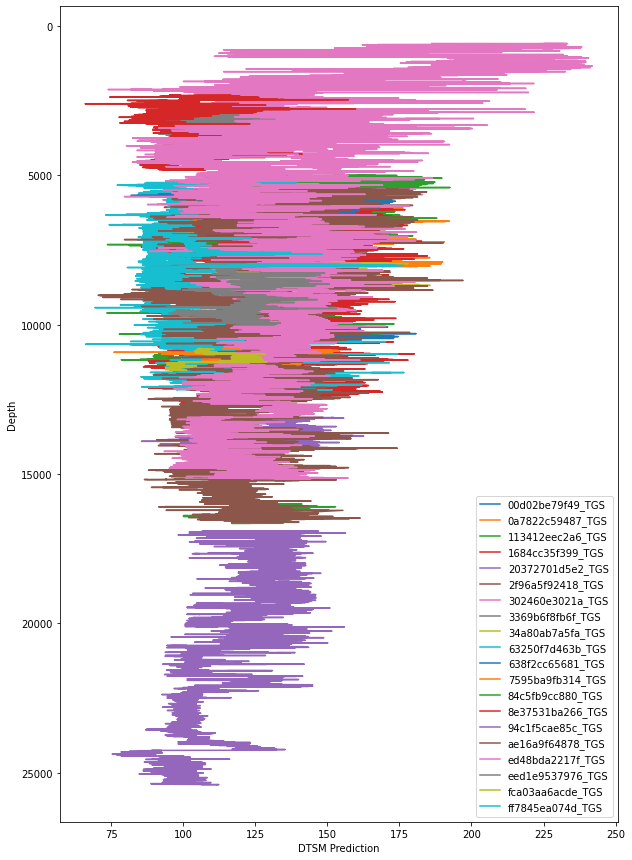

In [20]:
plt.figure(figsize=(10, 15))
for well in df_test2['WELL'].unique():
    plt.plot(df_test2.loc[df_test['WELL'] == well, 'DTSM_PRED'], 
             df_test2.loc[df_test['WELL'] == well, 'DEPT'], label=well[:-4])
plt.xlabel('DTSM Prediction')
plt.ylabel('Depth')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

## Submission

In [21]:
# Export prediction outputs to Excel files
for well in df_test2['WELL'].unique():
    submission = df_test2.loc[df_test2['WELL'] == well, ['DEPT', 'DTSM_PRED']]
    submission.columns = ['Depth', 'DTSM']
    submission.to_excel('submission/' + well[:-4] + '.xlsx', index=False)

In [22]:
# Compress to zip 
with zipfile.ZipFile('submission/DoaIbu.zip', 'w') as zipF:
    for file in os.listdir('submission'):
        if file.endswith('.xlsx'):
            zipF.write(os.getcwd() + '/submission/' + file, file)